# Cellular automata as convolutional neural networks

This notebook is based on the following paper and code:

> Gilpin, William. *Cellular Automata as Convolutional Neural Networks*. Phys. Rev. E 100 (September 2019): 032402. DOI: 10.1103/PhysRevE.100.032402
> [https://github.com/williamgilpin/convoca](https://github.com/williamgilpin/convoca)

## Setup

Required packages:

In [1]:
import sys
import os
import warnings 

sys.path.insert(0, os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib.animation import FuncAnimation
from IPython.display import Image, YouTubeVideo
from sklearn.preprocessing import MinMaxScaler

from ca_funcs import make_glider, make_game_of_life
from utils import *
from train_ca import *

plt.rcParams['figure.dpi'] = 300

Helper functions:

In [2]:
gol = make_game_of_life()


def play_game(init_state, steps):
    states = [tf.cast(init_state, tf.float32)]
    
    for i in range(steps):
        states.append(gol(states[-1])[None, ...])
        
    return states


def play_game_with_model(init_state, model, steps):
    states = [tf.cast(init_state, tf.float32)]
    
    for i in range(steps):
        next_state = model(states[-1])
        states.append(logit_to_pred(next_state, (1, BOARD_SIZE, BOARD_SIZE)))
        
    return states


def create_gif(states, title, filename):
    
    def create_frame(i):
        plt.clf()
        plt.imshow(1 - states[i][0], cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.tight_layout()
        return []
    
    fig, _ = plt.subplots()
    animation = FuncAnimation(fig, create_frame, frames=len(states), interval=125, repeat=True)
    animation.save(filename, writer='Pillow', fps=8)
    plt.close()


def plot_gif(filename):
    with open(filename, 'rb') as img:
        display(Image(data=img.read(), format='png', width=400, height=400))

## Cellular automata

A cellular automata is a discrete computational model consisting of a grid of cells, each in one of a finite number of states. These cells evolve through a series of discrete time steps based on a set of predefined rules, determined by the states of neighboring cells. The system's state at any given time is a function of its initial state and the applied rules.

### Applications - traffic simulaiton

"[Rule 184](https://en.wikipedia.org/wiki/Rule_184) can be used as a simple model for traffic flow in a single lane of a highway, and forms the basis for many cellular automaton models of traffic flow with greater sophistication. In this model, particles (representing vehicles) move in a single direction, stopping and starting depending on the cars in front of them. The number of particles remains unchanged throughout the simulation. Because of this application, Rule 184 is sometimes called the *traffic rule*."

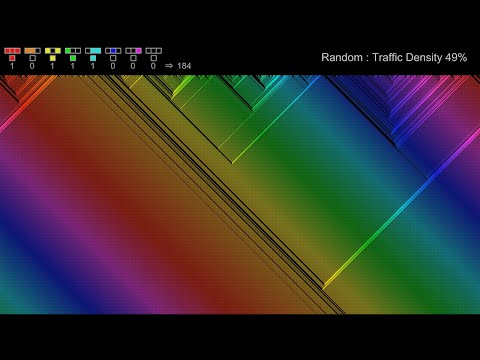

In [3]:
YouTubeVideo('9Mp6euku2PU', width=1400, height=780)

### Game of Life

Game of Life is a cellular automata with an infinite, two-dimensional orthogonal grid of square cells that follows this four rules:

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

MovieWriter Pillow unavailable; using Pillow instead.


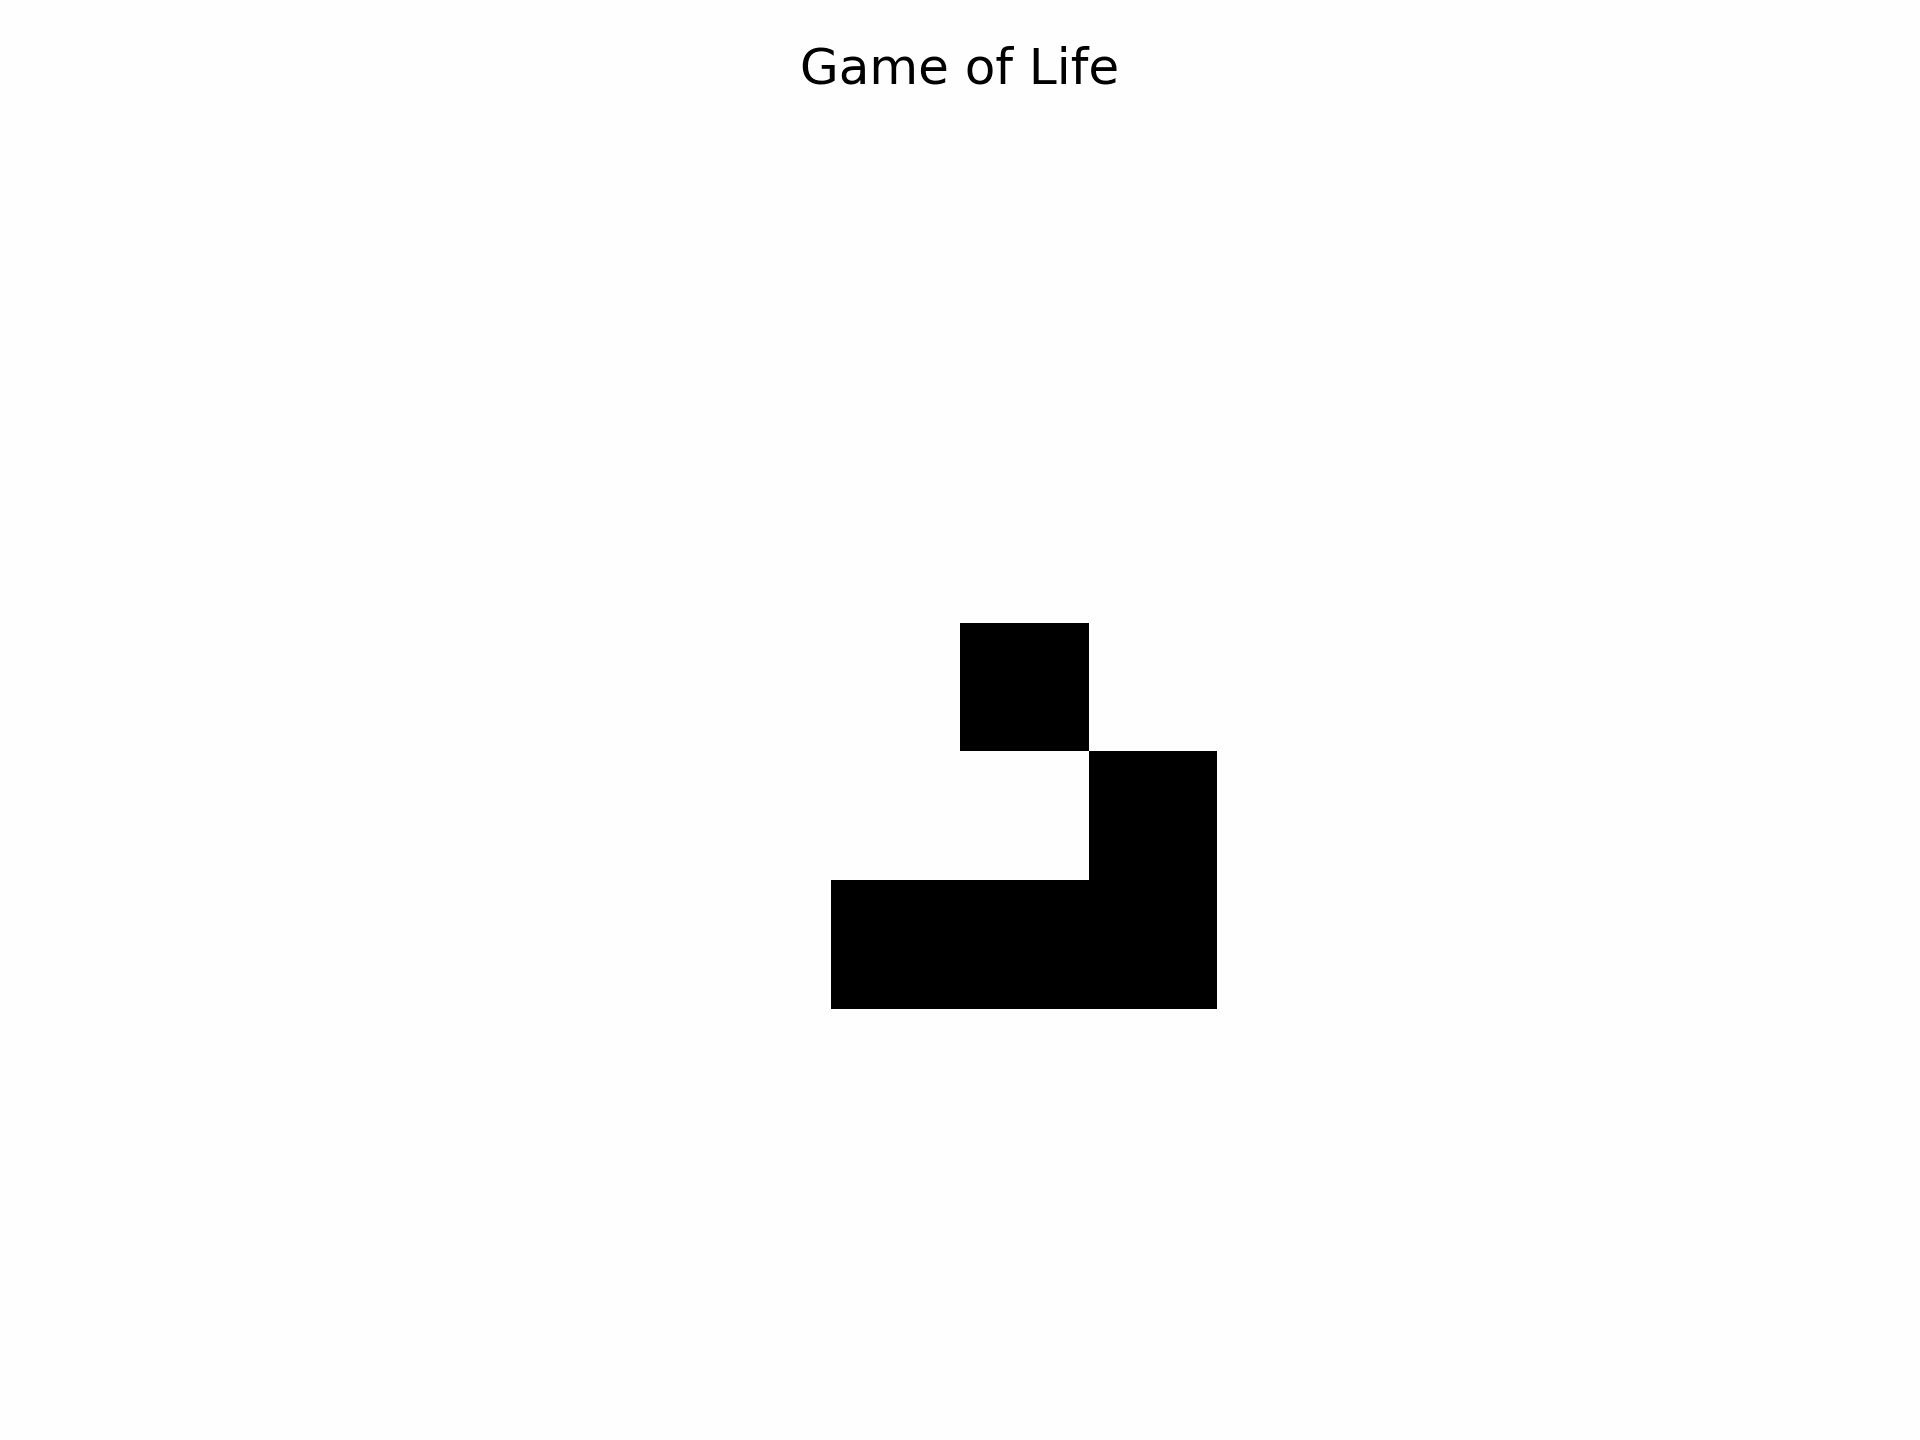

In [4]:
init_state = make_glider(dims0=10)[None, ...]
states = play_game(init_state, 40)
create_gif(states, 'Game of Life', 'images/gol.gif')
plot_gif('images/gol.gif')

## Convolutional neural network

### Game of Life as CNN

We can define a cellular automata as a convolutional neural network (CNN) in the following way: "two convolutional filters identify the value of the center pixel and count the number of neighbors. These features are then scored and summed to generate a prediction for the system at the next timestep".

<img src="images/cnn_ca.png" width=1400/>

### Architecture and parameters

<img src="images/architecture.png" width=1400/>
<img src="images/parameters.png" width=500/>

### Training

In [5]:
BOARD_SIZE = 10
N_SAMPLES = 500
NUM_CLASSES = 2

X_train = tf.random.categorical(tf.math.log([[0.5, 0.5]]), N_SAMPLES * BOARD_SIZE * BOARD_SIZE)
X_train = tf.cast(X_train, tf.float32)
X_train = tf.reshape(X_train, (N_SAMPLES, BOARD_SIZE, BOARD_SIZE))

Y_train = gol(X_train)
Y_train = tf.cast(Y_train, tf.int32)
Y_train = tf.one_hot(Y_train, NUM_CLASSES)
Y_train = tf.reshape(Y_train, (N_SAMPLES, BOARD_SIZE * BOARD_SIZE, NUM_CLASSES))

In [6]:
LAYER_DIMS = 12 * [100]
LEARNING_RATE = 1e-4

model = initialize_model((BOARD_SIZE, BOARD_SIZE), LAYER_DIMS, num_classes=NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound2d (Wraparound2D  (None, 12, 12, 1)         0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 100)       1000      
                                                                 
 reshape (Reshape)           (None, 100, 100)          0         
                                                                 
 dense (Dense)               (None, 100, 100)          10100     
                                                                 
 dense_1 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 100, 100)          10100     
                                                        

In [7]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=10, verbose=0)

2023-10-08 16:48:09.862574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


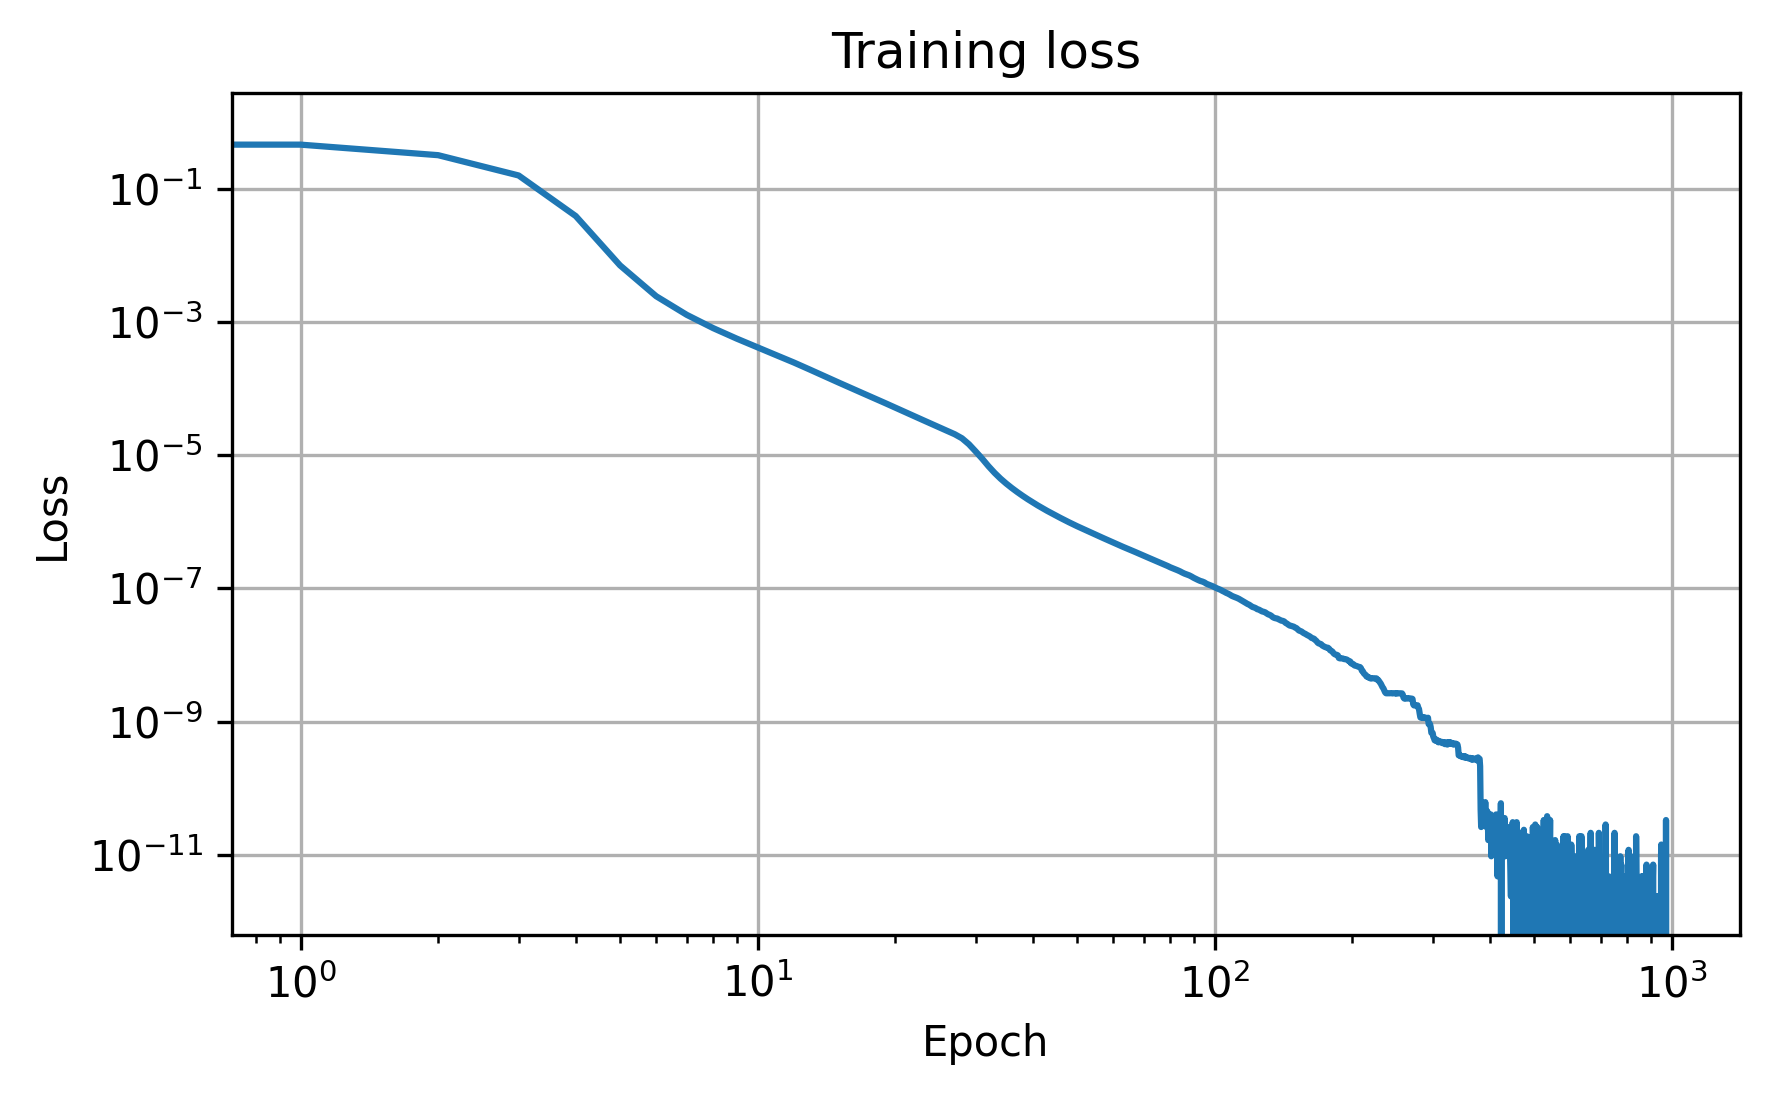

In [8]:
fig, ax = plt.subplots(figsize=(6, 6 / 1.6))

ax.plot(history.history['loss'])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training loss')

ax.grid()
plt.tight_layout()

plt.savefig('images/loss.png', dpi=300)
plt.show()

In [9]:
model.save('models/model.keras')
# model = tf.keras.models.load_model('models/model.keras', custom_objects={'Wraparound2D': Wraparound2D}, safe_mode=False)

### Demo

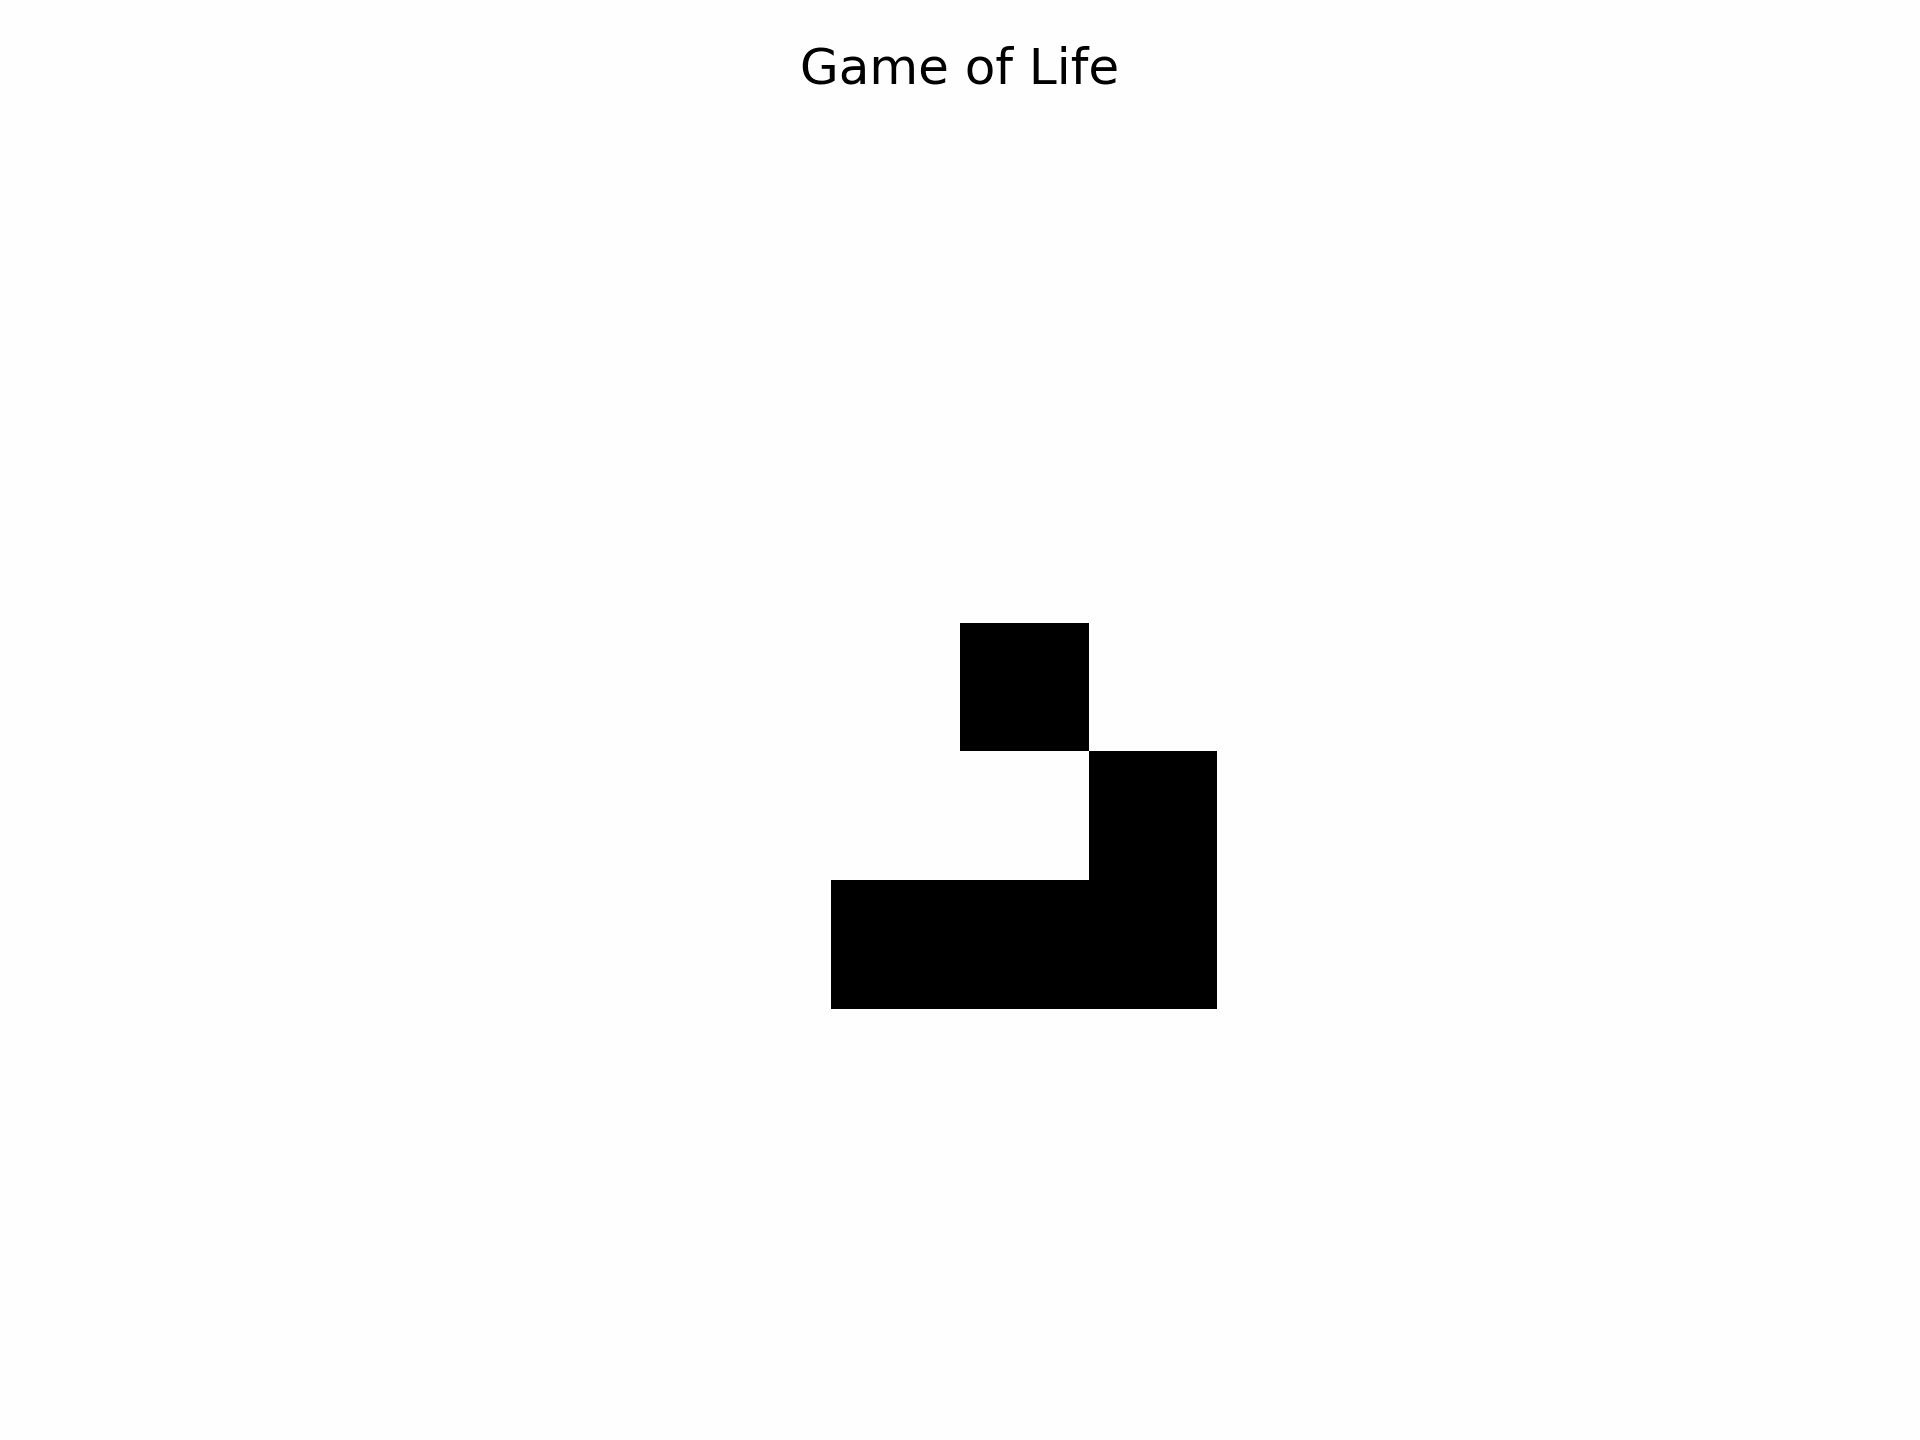

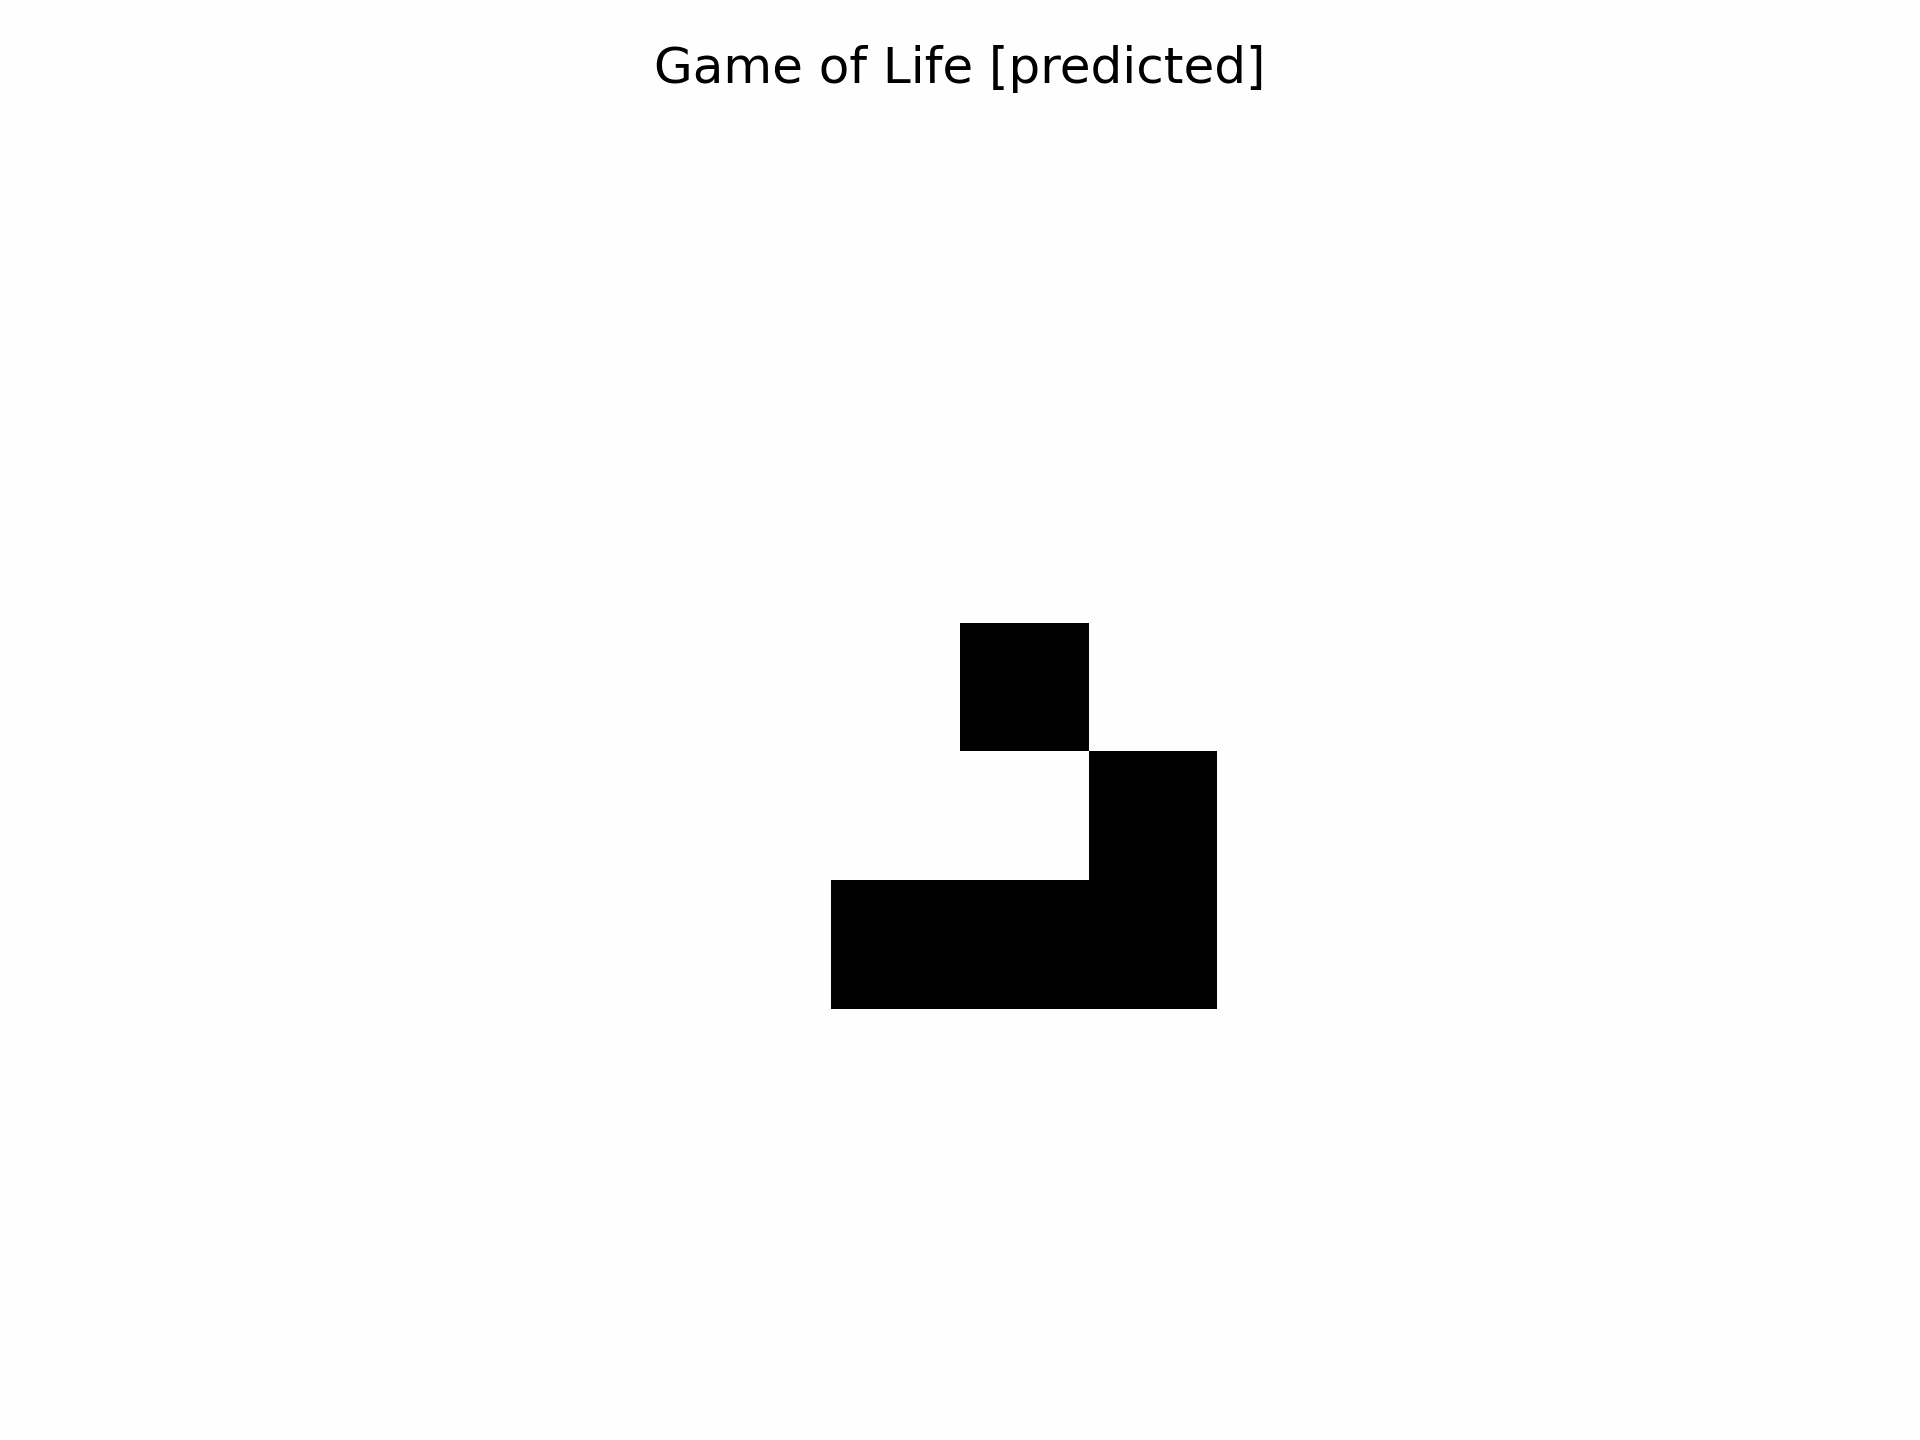

In [10]:
STEPS = 40

init_state = make_glider(dims0=BOARD_SIZE)[None, ...]
pred_states = play_game_with_model(init_state, model, STEPS)

create_gif(pred_states, 'Game of Life [predicted]', 'images/gol_pred.gif')
plot_gif('images/gol.gif')
plot_gif('images/gol_pred.gif')

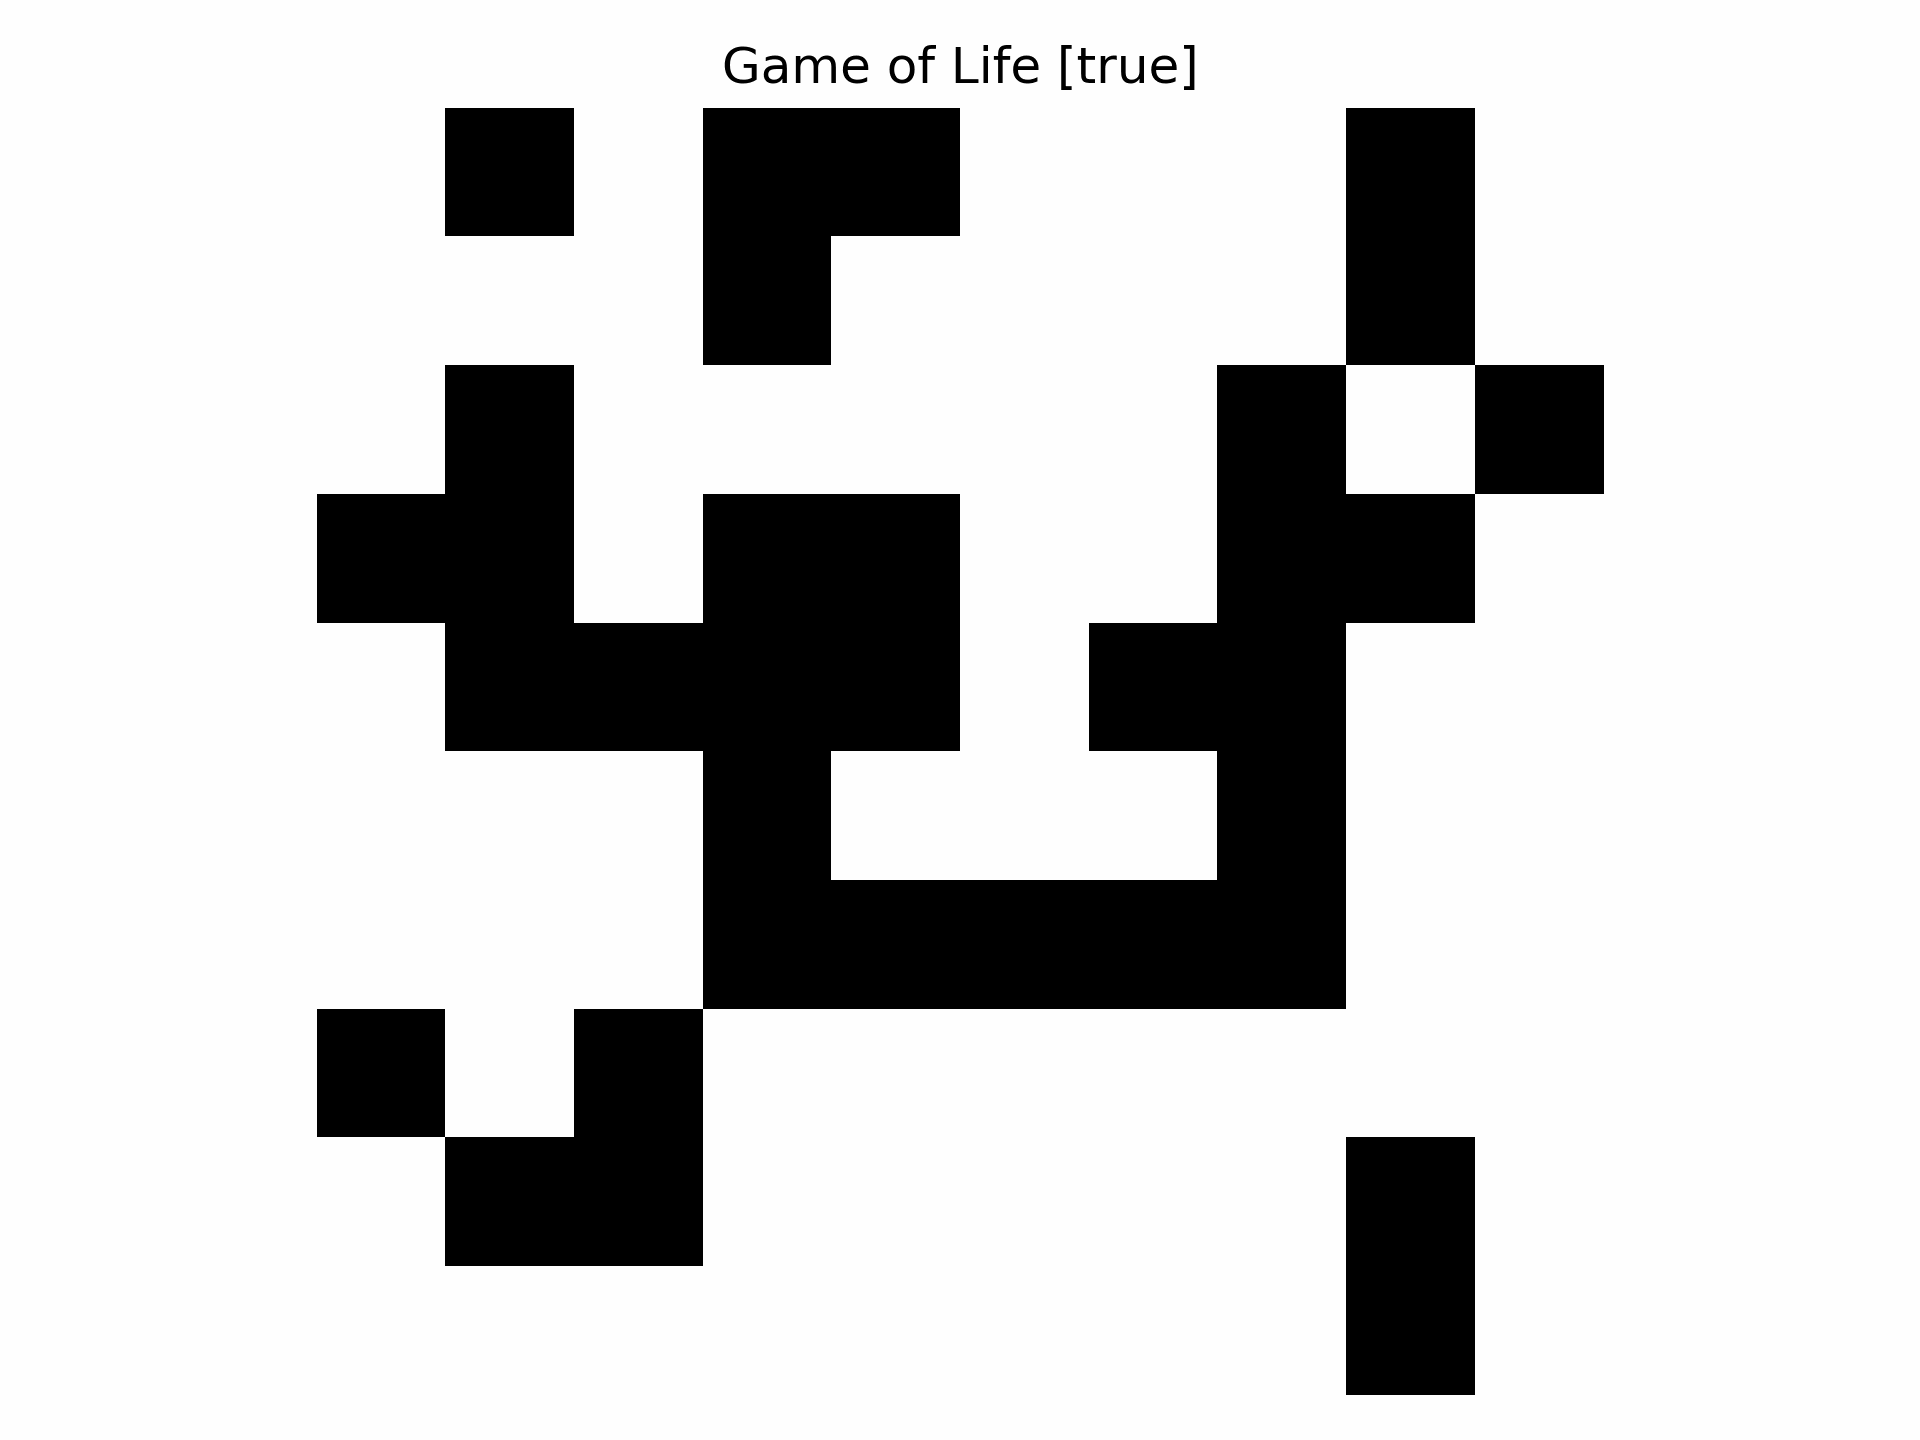

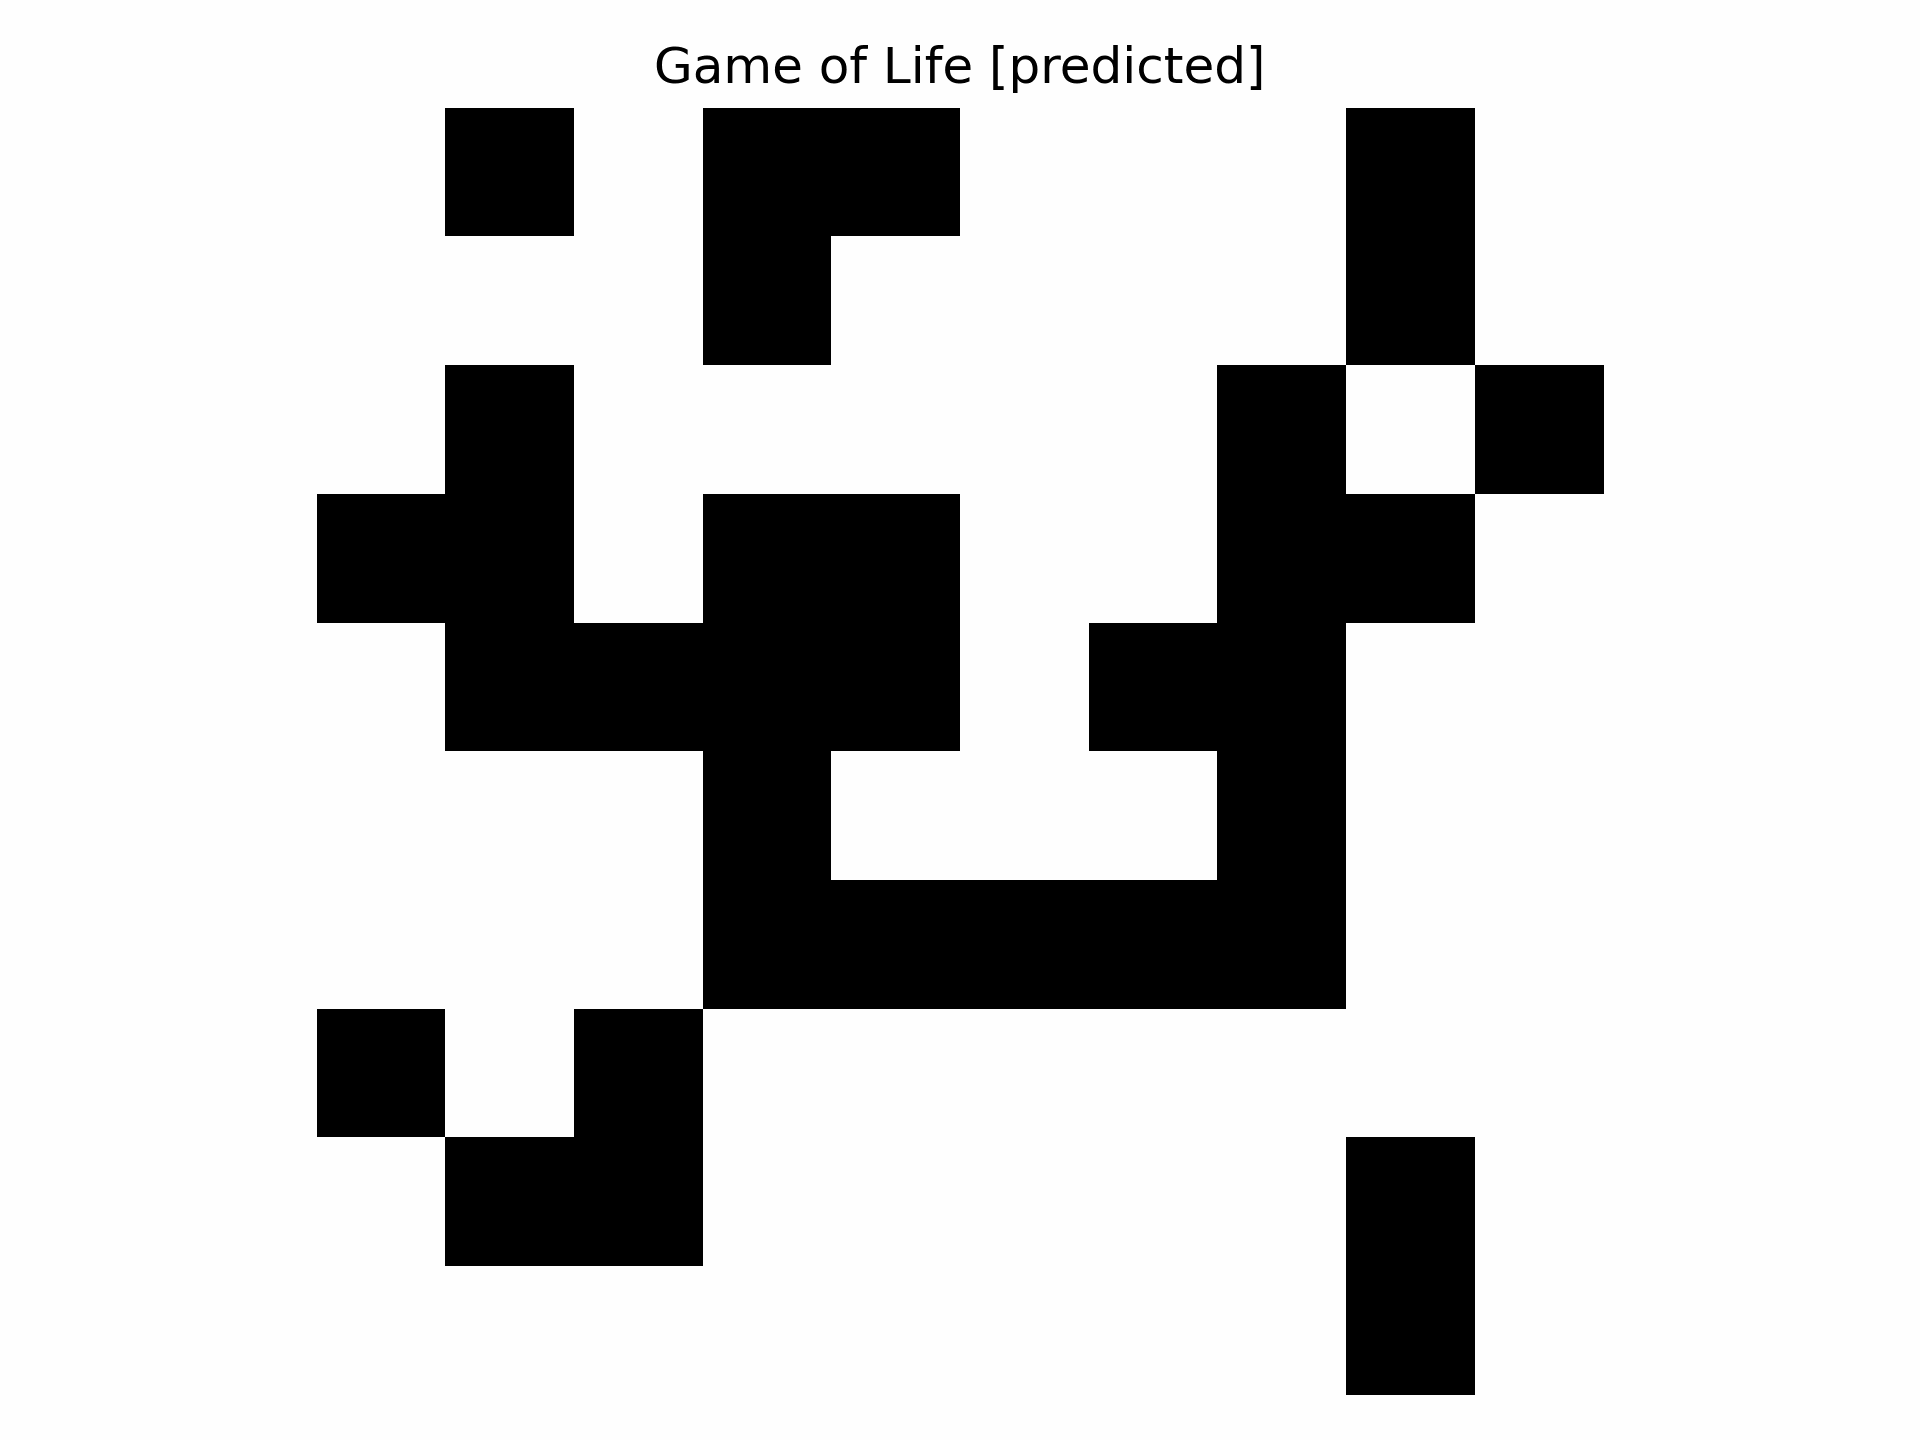

In [11]:
STEPS = 100

init_state = tf.random.categorical(tf.math.log([[0.7, 0.3]]), BOARD_SIZE * BOARD_SIZE)
init_state = tf.cast(init_state, tf.float32)
init_state = tf.reshape(init_state, (1, BOARD_SIZE, BOARD_SIZE))

true_states = play_game(init_state, STEPS)
pred_states = play_game_with_model(init_state, model, STEPS)
    
create_gif(true_states, 'Game of Life [true]', 'images/random_true.gif')
create_gif(pred_states, 'Game of Life [predicted]', 'images/random_pred.gif')

plot_gif('images/random_true.gif')
plot_gif('images/random_pred.gif')

### Dependence of training results on rule entropy

"Training 2560 convolutional neural networks on random cellular automata. (a) A network trained on the Game of Life for different durations, and then applied to images of each stage of the “glider” solution. (b) The loss versus time during training, colored by the rule entropy $H_{ca}$."

![Training](images/training.png)

### Activation of hidden layers

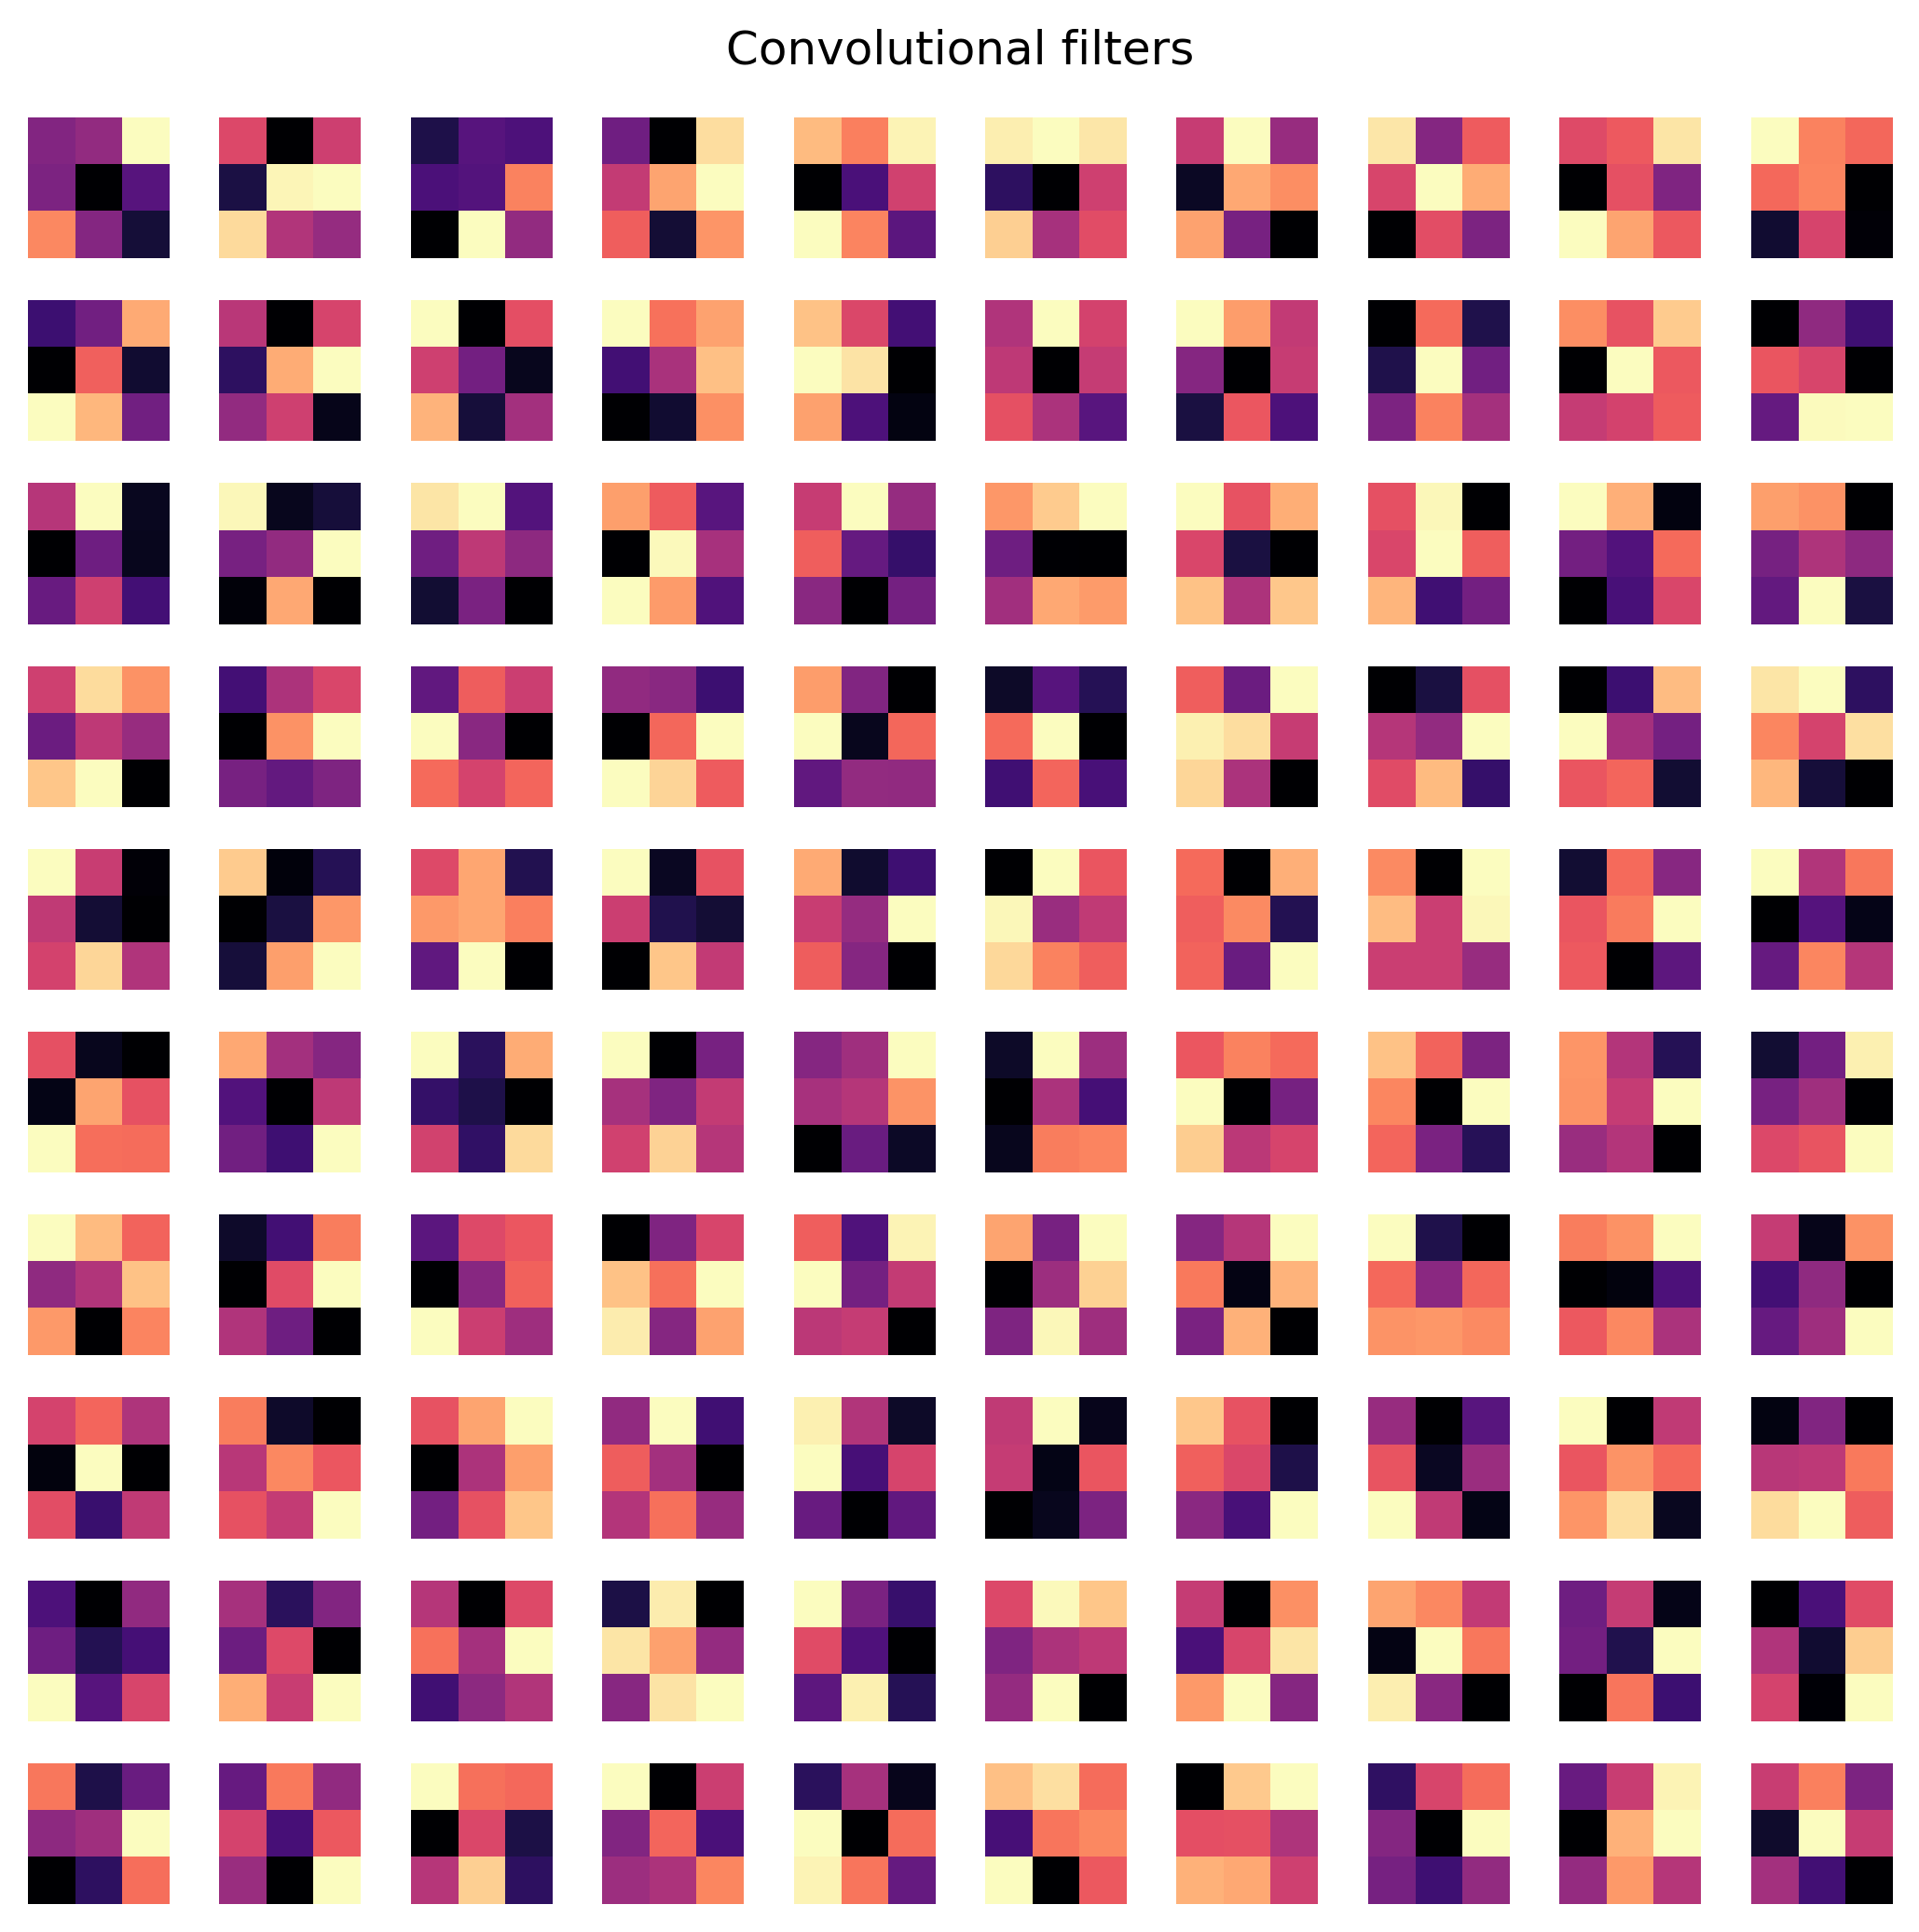

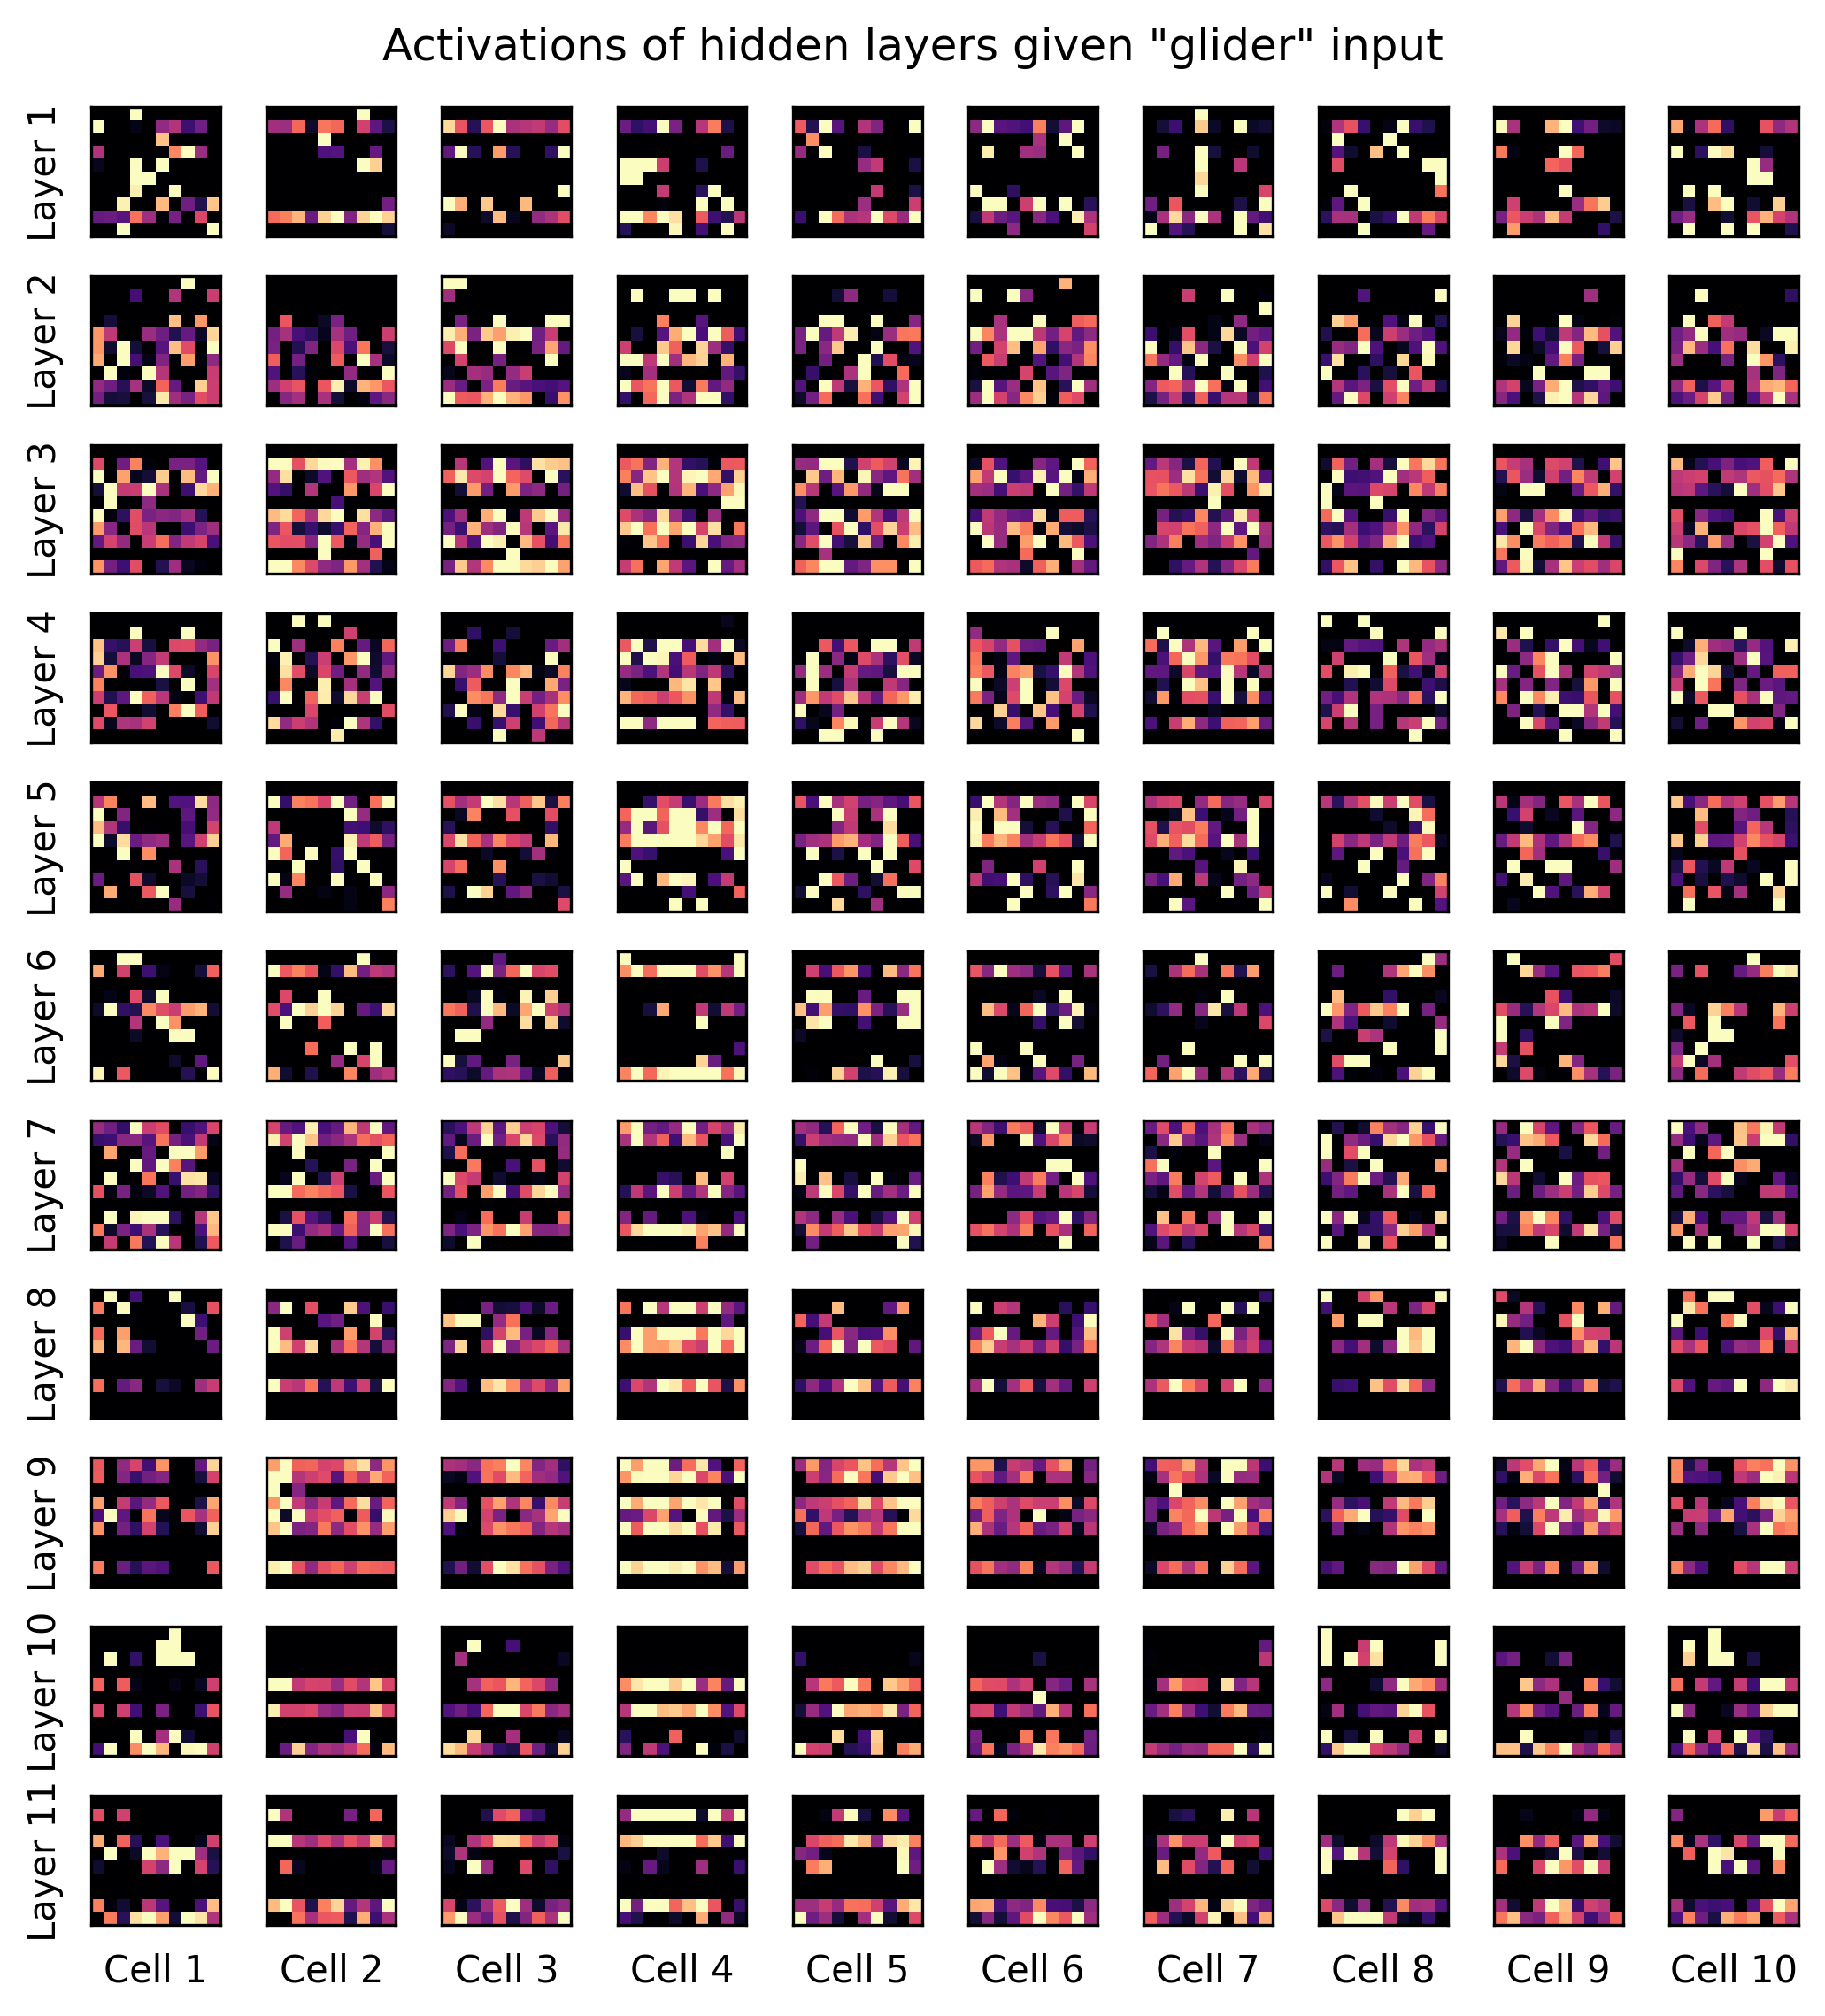

In [12]:
outputs = [layer.output for layer in model.layers]
functor = K.function(model.input, outputs)
layer_outs = functor([X_train[0][None, ...]])

_, axes = plt.subplots(10, 10, figsize=(7, 7))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(model.layers[1].weights[0].numpy()[..., 0, i * 10 + j], cmap='magma')
        axes[i, j].axis('off')

plt.suptitle("Convolutional filters")
plt.tight_layout()
plt.show()

all_layer_activations = []

for j in range(2, len(outputs) - 2):
    if j == 1:
        layer_im = np.hstack([MinMaxScaler().fit_transform(layer_outs[j][0][..., i]) for i in range(BOARD_SIZE)])
    else:
        pattern = np.reshape(layer_outs[j][0], (BOARD_SIZE, BOARD_SIZE, -1))
        layer_im = np.hstack([MinMaxScaler().fit_transform(pattern[..., i]) for i in range(BOARD_SIZE)])

    all_layer_activations.append(layer_im)

n, m = len(all_layer_activations), len(all_layer_activations[0])
_, axes = plt.subplots(n, m, figsize=(m * 0.7, n * 0.7))

for i, layer in enumerate(all_layer_activations):
    for j, activation in enumerate(layer):
        axes[i, j].imshow(activation.reshape(BOARD_SIZE, BOARD_SIZE), cmap='magma')
        axes[i, j].tick_params(axis='both', which='both', length=0)
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, 0].set_ylabel(f'Layer {i + 1}')
        axes[-1, j].set_xlabel(f'Cell {j + 1}')

plt.suptitle("Activations of hidden layers given \"glider\" input")
plt.tight_layout()
plt.show()

"Because the intrinsic entropy of the CA rule table affects training, we reason that the entropy of activated representations at each layer is a natural heuristic for analyzing the internal states of the network. [...] Early layers in the network tend to generate a broad set of activation patterns that closely follow the uniform input symbol distribution [...] however, in deeper layers progressively lower entropies are observed, consistent with fewer unique activation patterns [...]. These trends depend strongly on the CA rules."

![Entropy of CNN layers](images/entropy.png)